In [1]:
import numpy as np 
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import tensorflow as tf
import cv2

from PIL import Image, ImageOps
import scipy.ndimage as ndi

import matplotlib.pyplot as plt

from skimage import transform
import splitfolders
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix

import math
import warnings
from pathlib import Path
warnings.filterwarnings(action='ignore')

# 1. Data Acquisition

In [2]:
input_path = Path("./")
output_path = Path("./")
raw_dataset_name = "kidney_disease.csv"
data=pd.read_csv(input_path/ raw_dataset_name)

In [3]:
os.listdir('CTscaninput')

['CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone']

In [4]:
os.listdir('CTscaninput/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/')

['Cyst', 'Normal', 'Stone', 'Tumor']

In [5]:
data.head(10)

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,228.0,60.0,70.0,NaN,NaN,NaN,NaN,NaN,notpresent,present,...,NaN,NaN,NaN,yes,no,no,good,no,no,ckd
1,28.0,75.0,70.0,NaN,1.0,3.0,NaN,NaN,notpresent,present,...,NaN,NaN,NaN,no,yes,no,good,no,no,ckd
2,125.0,72.0,90.0,NaN,NaN,NaN,NaN,NaN,notpresent,present,...,NaN,NaN,NaN,yes,yes,yes,good,no,no,ckd
3,215.0,30.0,70.0,1.010,3.0,0.0,NaN,normal,notpresent,notpresent,...,NaN,NaN,NaN,no,no,no,good,no,no,ckd
4,201.0,64.0,70.0,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,...,21.0,NaN,NaN,yes,yes,no,good,no,no,ckd
5,70.0,61.0,80.0,1.015,0.0,4.0,NaN,normal,notpresent,notpresent,...,44.0,8300.0,5.2,yes,yes,no,good,no,no,ckd
6,170.0,66.0,70.0,1.015,2.0,5.0,NaN,normal,notpresent,present,...,33.0,9600.0,4.4,yes,yes,no,good,yes,yes,ckd
7,328.0,28.0,70.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,45.0,8600.0,6.5,no,no,no,good,no,no,notckd
8,366.0,34.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,46.0,10500.0,5.3,no,no,no,poor,yes,yes,notckd
9,394.0,48.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,45.0,9500.0,4.6,no,no,no,poor,yes,yes,notckd


We can see there are missing values.
If their number is considerable, then we'd have to be careful about which imputation technique to use.
There is also an extra 'id' column that needs to be dropped.

In [6]:
data.columns

Index(['id', 'age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr',
       'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'classification'],
      dtype='object')

In [7]:
for i in data.drop("id",axis=1).columns:
    print('unique values in "{}":\n'.format(i),data[i].unique())

unique values in "age":
 [60. 75. 72. 30. 64. 61. 66. 28. 34. 48. 25. 55. 52. 58. 67. 46. 47. 56.
 53. 54. 90. 70. 42. 73. 41. 76. nan 29. 39. 62. 21. 59. 17. 50. 43. 26.
 63. 24. 69. 35. 44. 57. 65. 27. 33. 45. 80. 79. 37. 32. 11. 40. 51. 19.
 38. 68. 71. 49. 74. 20. 15. 82. 78.  5. 23. 81. 83. 36. 12.  6.  3. 22.
  7. 31. 14.  2.  8. 13.  4.]
unique values in "bp":
 [ 70.  90.  80.  60. 100.  nan  50. 110. 140. 180. 120.]
unique values in "sg":
 [  nan 1.01  1.015 1.02  1.025 1.005]
unique values in "al":
 [nan  1.  3.  0.  2.  4.  5.]
unique values in "su":
 [nan  3.  0.  4.  5.  1.  2.]
unique values in "rbc":
 [nan 'normal' 'abnormal']
unique values in "pc":
 [nan 'normal' 'abnormal']
unique values in "pcc":
 ['notpresent' 'present' nan]
unique values in "ba":
 ['present' 'notpresent' nan]
unique values in "bgr":
 [124. 123. 308. 101. 113. 360. 447. 131.  nan 122.  82.  91. 119. 121.
 140. 104. 125.  99.  94. 117. 182. 165. 138. 213. 297. 207. 139. 144.
 184.  98. 109. 169. 137. 1

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8846 entries, 0 to 8845
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              8845 non-null   float64
 1   age             8659 non-null   float64
 2   bp              8727 non-null   float64
 3   sg              7848 non-null   float64
 4   al              7868 non-null   float64
 5   su              7843 non-null   float64
 6   rbc             5415 non-null   object 
 7   pc              7475 non-null   object 
 8   pcc             8794 non-null   object 
 9   ba              8715 non-null   object 
 10  bgr             8108 non-null   float64
 11  bu              8388 non-null   float64
 12  sc              8443 non-null   float64
 13  sod             6899 non-null   float64
 14  pot             8836 non-null   float64
 15  hemo            7587 non-null   float64
 16  pcv             7188 non-null   float64
 17  wc              6451 non-null   f

In [9]:
data.describe()

,id,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc
count,8845.000000,8659.000000,8727.000000,7848.000000,7868.000000,7843.000000,8108.000000,8388.000000,8443.000000,6899.000000,8836.000000,7587.000000,7188.000000,6451.000000,5967.000000
mean,202.033239,52.176464,76.078836,1.017769,0.923360,0.453908,148.255303,56.425107,3.100598,138.037179,5.287042,12.676592,39.153589,8338.412649,4.742232
std,117.805752,16.131406,13.755243,0.005714,1.326116,1.109538,80.403629,52.404056,5.840492,9.589783,5.259288,2.892568,8.855365,3146.862627,0.972279
min,0.000000,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,102.000000,42.000000,70.000000,1.015000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,4.000000,10.600000,33.000000,6600.000000,4.000000
50%,201.000000,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,40.000000,1.200000,139.000000,4.600000,13.000000,41.000000,7900.000000,4.800000
75%,308.000000,65.000000,80.000000,1.025000,2.000000,0.000000,158.000000,60.000000,2.700000,142.000000,5.000000,15.000000,46.000000,9600.000000,5.500000
max,399.000000,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,92000.000000,6.500000


In [10]:
path_main = 'CTscaninput/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/'
for folder in os.listdir(path_main):
    list_of_elements = os.listdir(os.path.join(path_main, folder)) 
    print(f'Folder: {folder}\n')
    print(f'Number of elements: {len(list_of_elements)}\n')
    print(f'First item\'s name: {list_of_elements[0]}\n')
    print('***************************') 

Folder: Cyst

Number of elements: 3709

First item's name: Cyst- (1).jpg

***************************
Folder: Normal

Number of elements: 5077

First item's name: Normal- (1).jpg

***************************
Folder: Stone

Number of elements: 1377

First item's name: Stone- (1).jpg

***************************
Folder: Tumor

Number of elements: 2283

First item's name: Tumor- (1).jpg

***************************


In [11]:
def plot_imgs(item_dir, num_imgs=25):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(10, 10))
    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)
        img = plt.imread(img_path)
        plt.title(f'{img_path}'[-10:-4])
        plt.imshow(img)

    plt.tight_layout()

In [12]:
path_normal = 'CTscaninput/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/'
path_stone = 'CTscaninput/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone/'
path_cyst = 'CTscaninput/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/'
path_tumor = 'CTscaninput/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/'

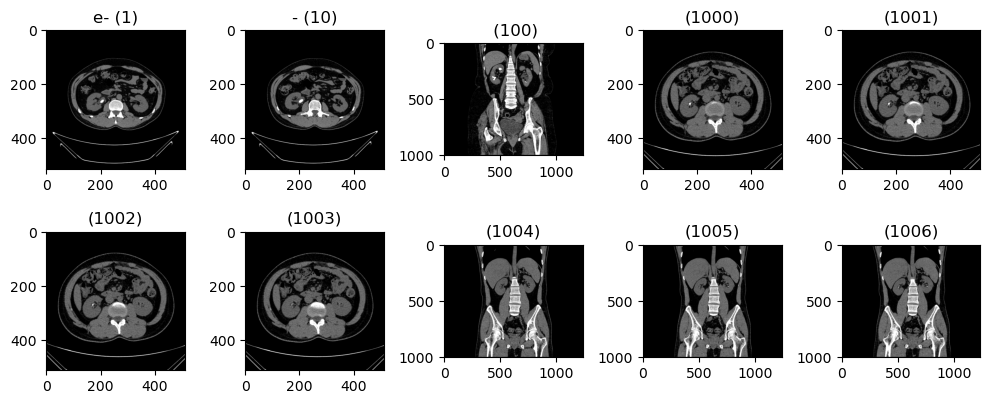

In [13]:
plot_imgs(path_stone, 10)

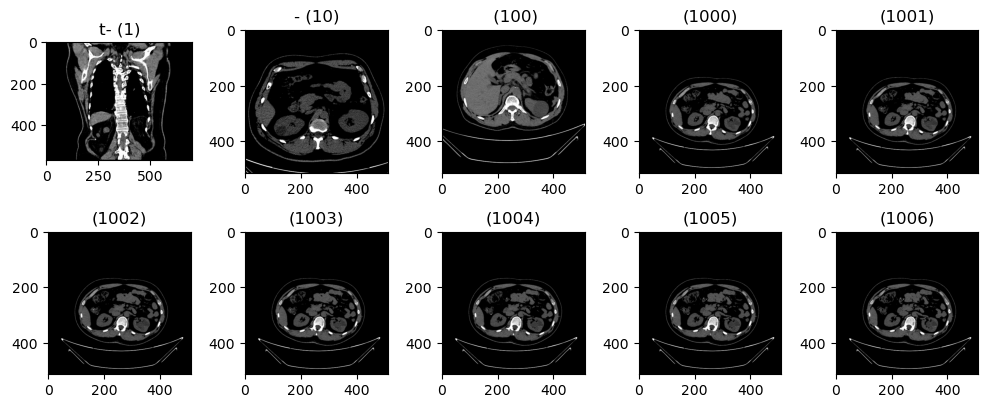

In [14]:
plot_imgs(path_cyst, 10)

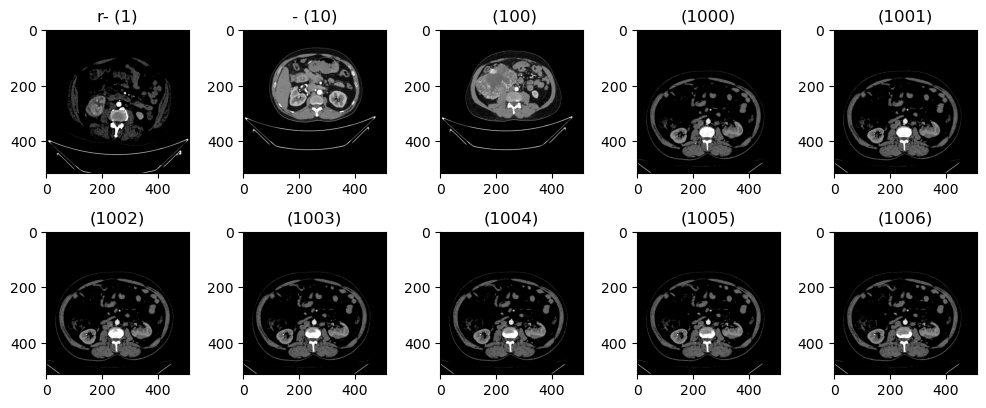

In [15]:
plot_imgs(path_tumor, 10)

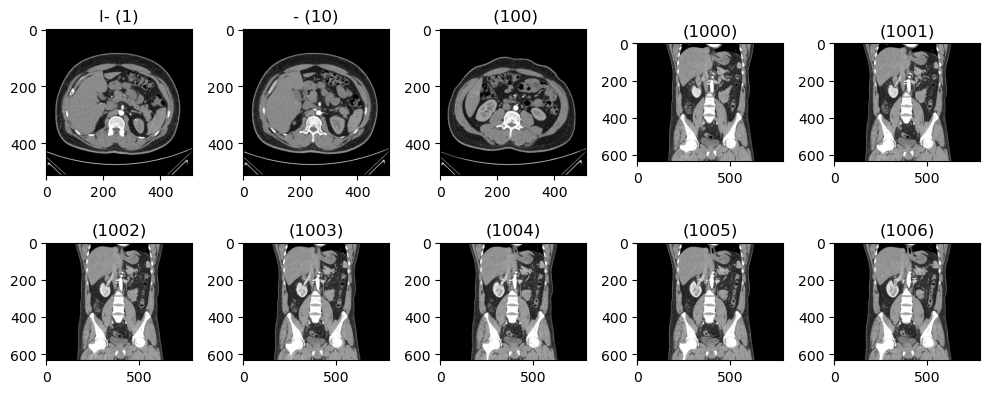

In [16]:
plot_imgs(path_normal, 10)

# 2. Data Cleaning

In [17]:
for i in range(data.shape[0]):
    if data.iloc[i,25]=='ckd\t':
        data.iloc[i,25]='ckd'
    if data.iloc[i,20] in [' yes','\tyes']:
        data.iloc[i,20]='yes'
    if data.iloc[i,20]=='\tno':
        data.iloc[i,20]='no'
    if data.iloc[i,21]=='\tno':
        data.iloc[i,21]='no'
    if data.iloc[i,16]=='\t?':
        data.iloc[i,16]=np.nan
    if data.iloc[i,16]=='\t43':
        data.iloc[i,16]='43'
    if data.iloc[i,17]=='\t?':
        data.iloc[i,17]=np.nan
    if data.iloc[i,17]=='\t6200':
        data.iloc[i,17]= '6200'
    if data.iloc[i,17]=='\t8400':
        data.iloc[i,17]= '6200'
    if data.iloc[i,18]=='\t?':
        data.iloc[i,18]=np.nan
    if data.iloc[i,25]=='ckd':
        data.iloc[i,25]='yes'
    if data.iloc[i,25]=='notckd':
        data.iloc[i,25]='no'

Now we drop that extra 'id' column.

In [18]:
data = data.drop('id',axis=1, )
data.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,60.0,70.0,NaN,NaN,NaN,NaN,NaN,notpresent,present,124.0,...,NaN,NaN,NaN,yes,no,no,good,no,no,yes
1,75.0,70.0,NaN,1.0,3.0,NaN,NaN,notpresent,present,123.0,...,NaN,NaN,NaN,no,yes,no,good,no,no,yes
2,72.0,90.0,NaN,NaN,NaN,NaN,NaN,notpresent,present,308.0,...,NaN,NaN,NaN,yes,yes,yes,good,no,no,yes
3,30.0,70.0,1.01,3.0,0.0,NaN,normal,notpresent,notpresent,101.0,...,NaN,NaN,NaN,no,no,no,good,no,no,yes
4,64.0,70.0,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,113.0,...,21.0,NaN,NaN,yes,yes,no,good,no,no,yes


In [19]:
feature_names=['Age(yrs)','BloodPressure(mm/Hg)','SpecificGravity','Albumin','Sugar','RedBloodCells',
               'PusCells','PusCellClumps','Bacteria','BloodGlucoseRandom(mgs/dL)','BloodUrea(mgs/dL)',
               'SerumCreatinine(mgs/dL)','Sodium(mEq/L)','Potassium(mEq/L)','Hemoglobin(gms)','PackedCellVolume',
               'WhiteBloodCells(cells/cmm)','RedBloodCells(millions/cmm)','Hypertension','DiabetesMellitus',
               'CoronaryArteryDisease','Appetite','PedalEdema','Anemia','ChronicKidneyDisease']
data.columns=feature_names

# 2.1 Remove Duplicates

In [20]:
for i in data.columns:
    print(f"unique values for column {i}:\n{data[i].unique()}\n")

unique values for column Age(yrs):
[60. 75. 72. 30. 64. 61. 66. 28. 34. 48. 25. 55. 52. 58. 67. 46. 47. 56.
 53. 54. 90. 70. 42. 73. 41. 76. nan 29. 39. 62. 21. 59. 17. 50. 43. 26.
 63. 24. 69. 35. 44. 57. 65. 27. 33. 45. 80. 79. 37. 32. 11. 40. 51. 19.
 38. 68. 71. 49. 74. 20. 15. 82. 78.  5. 23. 81. 83. 36. 12.  6.  3. 22.
  7. 31. 14.  2.  8. 13.  4.]

unique values for column BloodPressure(mm/Hg):
[ 70.  90.  80.  60. 100.  nan  50. 110. 140. 180. 120.]

unique values for column SpecificGravity:
[  nan 1.01  1.015 1.02  1.025 1.005]

unique values for column Albumin:
[nan  1.  3.  0.  2.  4.  5.]

unique values for column Sugar:
[nan  3.  0.  4.  5.  1.  2.]

unique values for column RedBloodCells:
[nan 'normal' 'abnormal']

unique values for column PusCells:
[nan 'normal' 'abnormal']

unique values for column PusCellClumps:
['notpresent' 'present' nan]

unique values for column Bacteria:
['present' 'notpresent' nan]

unique values for column BloodGlucoseRandom(mgs/dL):
[124. 123. 

Some numerical features are mistyped as strings.

In [21]:
mistyped=['PackedCellVolume','WhiteBloodCells(cells/cmm)','RedBloodCells(millions/cmm)']
numeric=[ i for i in data.columns if data[i].dtype=='float64']
numeric=numeric+mistyped

In [22]:
data[mistyped]=data[mistyped].astype('float')

In [23]:
print(data['PackedCellVolume'].unique())
print(data['WhiteBloodCells(cells/cmm)'].unique())
print(data['RedBloodCells(millions/cmm)'].unique())

[nan 21. 44. 33. 45. 46. 48. 40. 52. 43. 53. 41. 32. 34. 28. 39. 37. 36.
 26. 50. 23. 35. 51. 17. 14. 49. 24. 42. 27. 25. 29. 31. 22. 54. 38. 18.
 19. 16. 47. 30.  9. 20. 15.]
[   nan  8300.  9600.  8600. 10500.  9500.  9400.  9200.  6900.  6700.
  8200.  4700.  6800.  6300.  5300.  9100.  5200. 11800. 13600.  7900.
  8400.  5800.  9300. 12700.  9900.  5400. 12400. 10900. 11000.  7200.
  6500. 10700.  7800. 11400.  4300.  5600.  6400. 11500.  7500.  9800.
 10300.  8100.  5100. 21600. 12000. 15700.  6600. 12800. 10200.  4200.
  8000.  5500.  7000.  5700. 14600.  8800.  9000.  7300. 10400. 12100.
  2200.  6200.  9700. 15200.  5000.  7700.  7400.  3800.  8500. 14900.
  7100. 12500. 16300.  6000. 18900. 13200. 11300.  4500. 11200.  2600.
 16700. 12300.  5900. 19100.  4100. 26400. 10800. 11900.  6100. 55100.
 47000. 92000.]
[nan 5.2 4.4 6.5 5.3 4.6 4.9 4.8 6.1 5.9 4.1 5.6 5.  3.9 4.5 5.5 4.7 4.2
 3.4 5.7 4.3 5.1 6.  3.3 3.1 4.  3.2 3.8 3.5 6.4 2.9 5.8 3.  2.3 3.7 6.2
 2.6 2.4 5.4 3.6 2.1 6.

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8846 entries, 0 to 8845
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age(yrs)                     8659 non-null   float64
 1   BloodPressure(mm/Hg)         8727 non-null   float64
 2   SpecificGravity              7848 non-null   float64
 3   Albumin                      7868 non-null   float64
 4   Sugar                        7843 non-null   float64
 5   RedBloodCells                5415 non-null   object 
 6   PusCells                     7475 non-null   object 
 7   PusCellClumps                8794 non-null   object 
 8   Bacteria                     8715 non-null   object 
 9   BloodGlucoseRandom(mgs/dL)   8108 non-null   float64
 10  BloodUrea(mgs/dL)            8388 non-null   float64
 11  SerumCreatinine(mgs/dL)      8443 non-null   float64
 12  Sodium(mEq/L)                6899 non-null   float64
 13  Potassium(mEq/L)  

Now that we've dealt with that, let's separate categorical and numerical features, as they won't be dealt with the same way.
Numerical features were already put together in a list.

In [25]:
categoricals= data.select_dtypes(include=['object']).columns.tolist()
categoricals

['RedBloodCells',
 'PusCells',
 'PusCellClumps',
 'Bacteria',
 'Hypertension',
 'DiabetesMellitus',
 'CoronaryArteryDisease',
 'Appetite',
 'PedalEdema',
 'Anemia',
 'ChronicKidneyDisease']

In [26]:
data[categoricals]=data[categoricals].astype("category")

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8846 entries, 0 to 8845
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Age(yrs)                     8659 non-null   float64 
 1   BloodPressure(mm/Hg)         8727 non-null   float64 
 2   SpecificGravity              7848 non-null   float64 
 3   Albumin                      7868 non-null   float64 
 4   Sugar                        7843 non-null   float64 
 5   RedBloodCells                5415 non-null   category
 6   PusCells                     7475 non-null   category
 7   PusCellClumps                8794 non-null   category
 8   Bacteria                     8715 non-null   category
 9   BloodGlucoseRandom(mgs/dL)   8108 non-null   float64 
 10  BloodUrea(mgs/dL)            8388 non-null   float64 
 11  SerumCreatinine(mgs/dL)      8443 non-null   float64 
 12  Sodium(mEq/L)                6899 non-null   float64 
 13  Pot

Now that the data is cleaned, we need to deal with those missing values.
We'll do some further exploration first, as that could help us in picking a proper imputation method.

In [28]:
data.ChronicKidneyDisease.unique()

['yes', 'no']
Categories (2, object): ['no', 'yes']

In [29]:
data['ChronicKidneyDisease'] = data['ChronicKidneyDisease'].replace(['yes','no'], [1,0])

In [30]:
data.head()

,Age(yrs),BloodPressure(mm/Hg),SpecificGravity,Albumin,Sugar,RedBloodCells,PusCells,PusCellClumps,Bacteria,BloodGlucoseRandom(mgs/dL),...,PackedCellVolume,WhiteBloodCells(cells/cmm),RedBloodCells(millions/cmm),Hypertension,DiabetesMellitus,CoronaryArteryDisease,Appetite,PedalEdema,Anemia,ChronicKidneyDisease
0,60.0,70.0,NaN,NaN,NaN,NaN,NaN,notpresent,present,124.0,...,NaN,NaN,NaN,yes,no,no,good,no,no,1
1,75.0,70.0,NaN,1.0,3.0,NaN,NaN,notpresent,present,123.0,...,NaN,NaN,NaN,no,yes,no,good,no,no,1
2,72.0,90.0,NaN,NaN,NaN,NaN,NaN,notpresent,present,308.0,...,NaN,NaN,NaN,yes,yes,yes,good,no,no,1
3,30.0,70.0,1.01,3.0,0.0,NaN,normal,notpresent,notpresent,101.0,...,NaN,NaN,NaN,no,no,no,good,no,no,1
4,64.0,70.0,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,113.0,...,21.0,NaN,NaN,yes,yes,no,good,no,no,1


In [31]:
data

,Age(yrs),BloodPressure(mm/Hg),SpecificGravity,Albumin,Sugar,RedBloodCells,PusCells,PusCellClumps,Bacteria,BloodGlucoseRandom(mgs/dL),...,PackedCellVolume,WhiteBloodCells(cells/cmm),RedBloodCells(millions/cmm),Hypertension,DiabetesMellitus,CoronaryArteryDisease,Appetite,PedalEdema,Anemia,ChronicKidneyDisease
0,60.0,70.0,NaN,NaN,NaN,NaN,NaN,notpresent,present,124.0,...,NaN,NaN,NaN,yes,no,no,good,no,no,1
1,75.0,70.0,NaN,1.0,3.0,NaN,NaN,notpresent,present,123.0,...,NaN,NaN,NaN,no,yes,no,good,no,no,1
2,72.0,90.0,NaN,NaN,NaN,NaN,NaN,notpresent,present,308.0,...,NaN,NaN,NaN,yes,yes,yes,good,no,no,1
3,30.0,70.0,1.010,3.0,0.0,NaN,normal,notpresent,notpresent,101.0,...,NaN,NaN,NaN,no,no,no,good,no,no,1
4,64.0,70.0,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,113.0,...,21.0,NaN,NaN,yes,yes,no,good,no,no,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8841,24.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,93.0,...,NaN,10700.0,6.3,no,no,no,poor,yes,no,0
8842,68.0,90.0,1.015,5.0,0.0,NaN,normal,notpresent,notpresent,238.0,...,24.0,8000.0,3.3,yes,yes,no,poor,yes,yes,1
8843,35.0,80.0,1.010,1.0,0.0,abnormal,NaN,notpresent,notpresent,79.0,...,24.0,7900.0,3.1,no,yes,no,good,yes,yes,1
8844,50.0,70.0,1.020,3.0,0.0,abnormal,normal,notpresent,present,123.0,...,36.0,4700.0,NaN,no,no,no,poor,yes,yes,1


# 2.2 Fill missing values

In [32]:
data.isnull().sum()

Age(yrs)                        187
BloodPressure(mm/Hg)            119
SpecificGravity                 998
Albumin                         978
Sugar                          1003
RedBloodCells                  3431
PusCells                       1371
PusCellClumps                    52
Bacteria                        131
BloodGlucoseRandom(mgs/dL)      738
BloodUrea(mgs/dL)               458
SerumCreatinine(mgs/dL)         403
Sodium(mEq/L)                  1947
Potassium(mEq/L)                 10
Hemoglobin(gms)                1259
PackedCellVolume               1658
WhiteBloodCells(cells/cmm)     2395
RedBloodCells(millions/cmm)    2879
Hypertension                     40
DiabetesMellitus                 40
CoronaryArteryDisease            38
Appetite                          8
PedalEdema                        8
Anemia                            8
ChronicKidneyDisease              0
dtype: int64

In [33]:
df = data.dropna(axis = 0)
print(f"Before dropping all NaN values: {data.shape}")
print(f"After dropping all NaN values: {df.shape}")

Before dropping all NaN values: (8846, 25)
After dropping all NaN values: (3444, 25)


In [34]:
df.head()

,Age(yrs),BloodPressure(mm/Hg),SpecificGravity,Albumin,Sugar,RedBloodCells,PusCells,PusCellClumps,Bacteria,BloodGlucoseRandom(mgs/dL),...,PackedCellVolume,WhiteBloodCells(cells/cmm),RedBloodCells(millions/cmm),Hypertension,DiabetesMellitus,CoronaryArteryDisease,Appetite,PedalEdema,Anemia,ChronicKidneyDisease
9,48.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,122.0,...,45.0,9500.0,4.6,no,no,no,poor,yes,yes,0
10,30.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,82.0,...,45.0,9400.0,5.3,no,no,yes,poor,yes,yes,0
13,25.0,80.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,121.0,...,48.0,6900.0,5.3,no,no,no,good,no,no,0
14,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,...,45.0,6700.0,4.6,no,no,no,good,no,no,0
15,30.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,82.0,...,45.0,9400.0,5.3,no,no,no,good,no,no,0


In [35]:
df.Bacteria.unique()

['notpresent', 'present']
Categories (2, object): ['notpresent', 'present']

# 2.3 Feature splitting

In [36]:
df['RedBloodCells'] = df['RedBloodCells'].replace(['normal','abnormal'], [1,0])
df['PusCells'] = df['PusCells'].replace(['normal','abnormal'], [1,0])
df['PusCellClumps'] = df['PusCellClumps'].replace(['present','notpresent'], [1,0])
df['Bacteria'] = df['Bacteria'].replace(['present','notpresent'], [1,0])
df['Hypertension'] = data['Hypertension'].replace(['yes','no'], [1,0])
df['DiabetesMellitus'] = data['DiabetesMellitus'].replace(['yes','no'], [1,0])
df['CoronaryArteryDisease'] = df['CoronaryArteryDisease'].replace(['yes','no'], [1,0])
df['Appetite'] = df['Appetite'].replace(['good','poor'], [1,0])
df['PedalEdema'] = df['PedalEdema'].replace(['yes','no'], [1,0])
df['CoronaryArteryDisease'] = df['CoronaryArteryDisease'].replace(['yes','no'], [1,0])
df['Anemia'] = df['Anemia'].replace(['yes','no'], [1,0])

In [37]:
df

,Age(yrs),BloodPressure(mm/Hg),SpecificGravity,Albumin,Sugar,RedBloodCells,PusCells,PusCellClumps,Bacteria,BloodGlucoseRandom(mgs/dL),...,PackedCellVolume,WhiteBloodCells(cells/cmm),RedBloodCells(millions/cmm),Hypertension,DiabetesMellitus,CoronaryArteryDisease,Appetite,PedalEdema,Anemia,ChronicKidneyDisease
9,48.0,80.0,1.020,0.0,0.0,1,1,0,0,122.0,...,45.0,9500.0,4.6,0,0,0,0,1,1,0
10,30.0,80.0,1.020,0.0,0.0,1,1,0,0,82.0,...,45.0,9400.0,5.3,0,0,1,0,1,1,0
13,25.0,80.0,1.025,0.0,0.0,1,1,0,0,121.0,...,48.0,6900.0,5.3,0,0,0,1,0,0,0
14,55.0,80.0,1.020,0.0,0.0,1,1,0,0,140.0,...,45.0,6700.0,4.6,0,0,0,1,0,0,0
15,30.0,80.0,1.020,0.0,0.0,1,1,0,0,82.0,...,45.0,9400.0,5.3,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8829,59.0,50.0,1.010,3.0,0.0,1,0,0,0,241.0,...,31.0,15700.0,3.8,0,1,0,0,1,1,1
8830,59.0,50.0,1.010,3.0,0.0,1,0,0,0,241.0,...,31.0,15700.0,3.8,0,1,1,1,0,1,1
8832,73.0,70.0,1.005,0.0,0.0,1,1,0,0,70.0,...,29.0,18900.0,3.5,1,1,0,1,0,0,1
8833,73.0,60.0,1.020,2.0,0.0,0,1,0,0,120.0,...,33.0,7200.0,4.3,1,1,0,1,0,0,1


<AxesSubplot:>

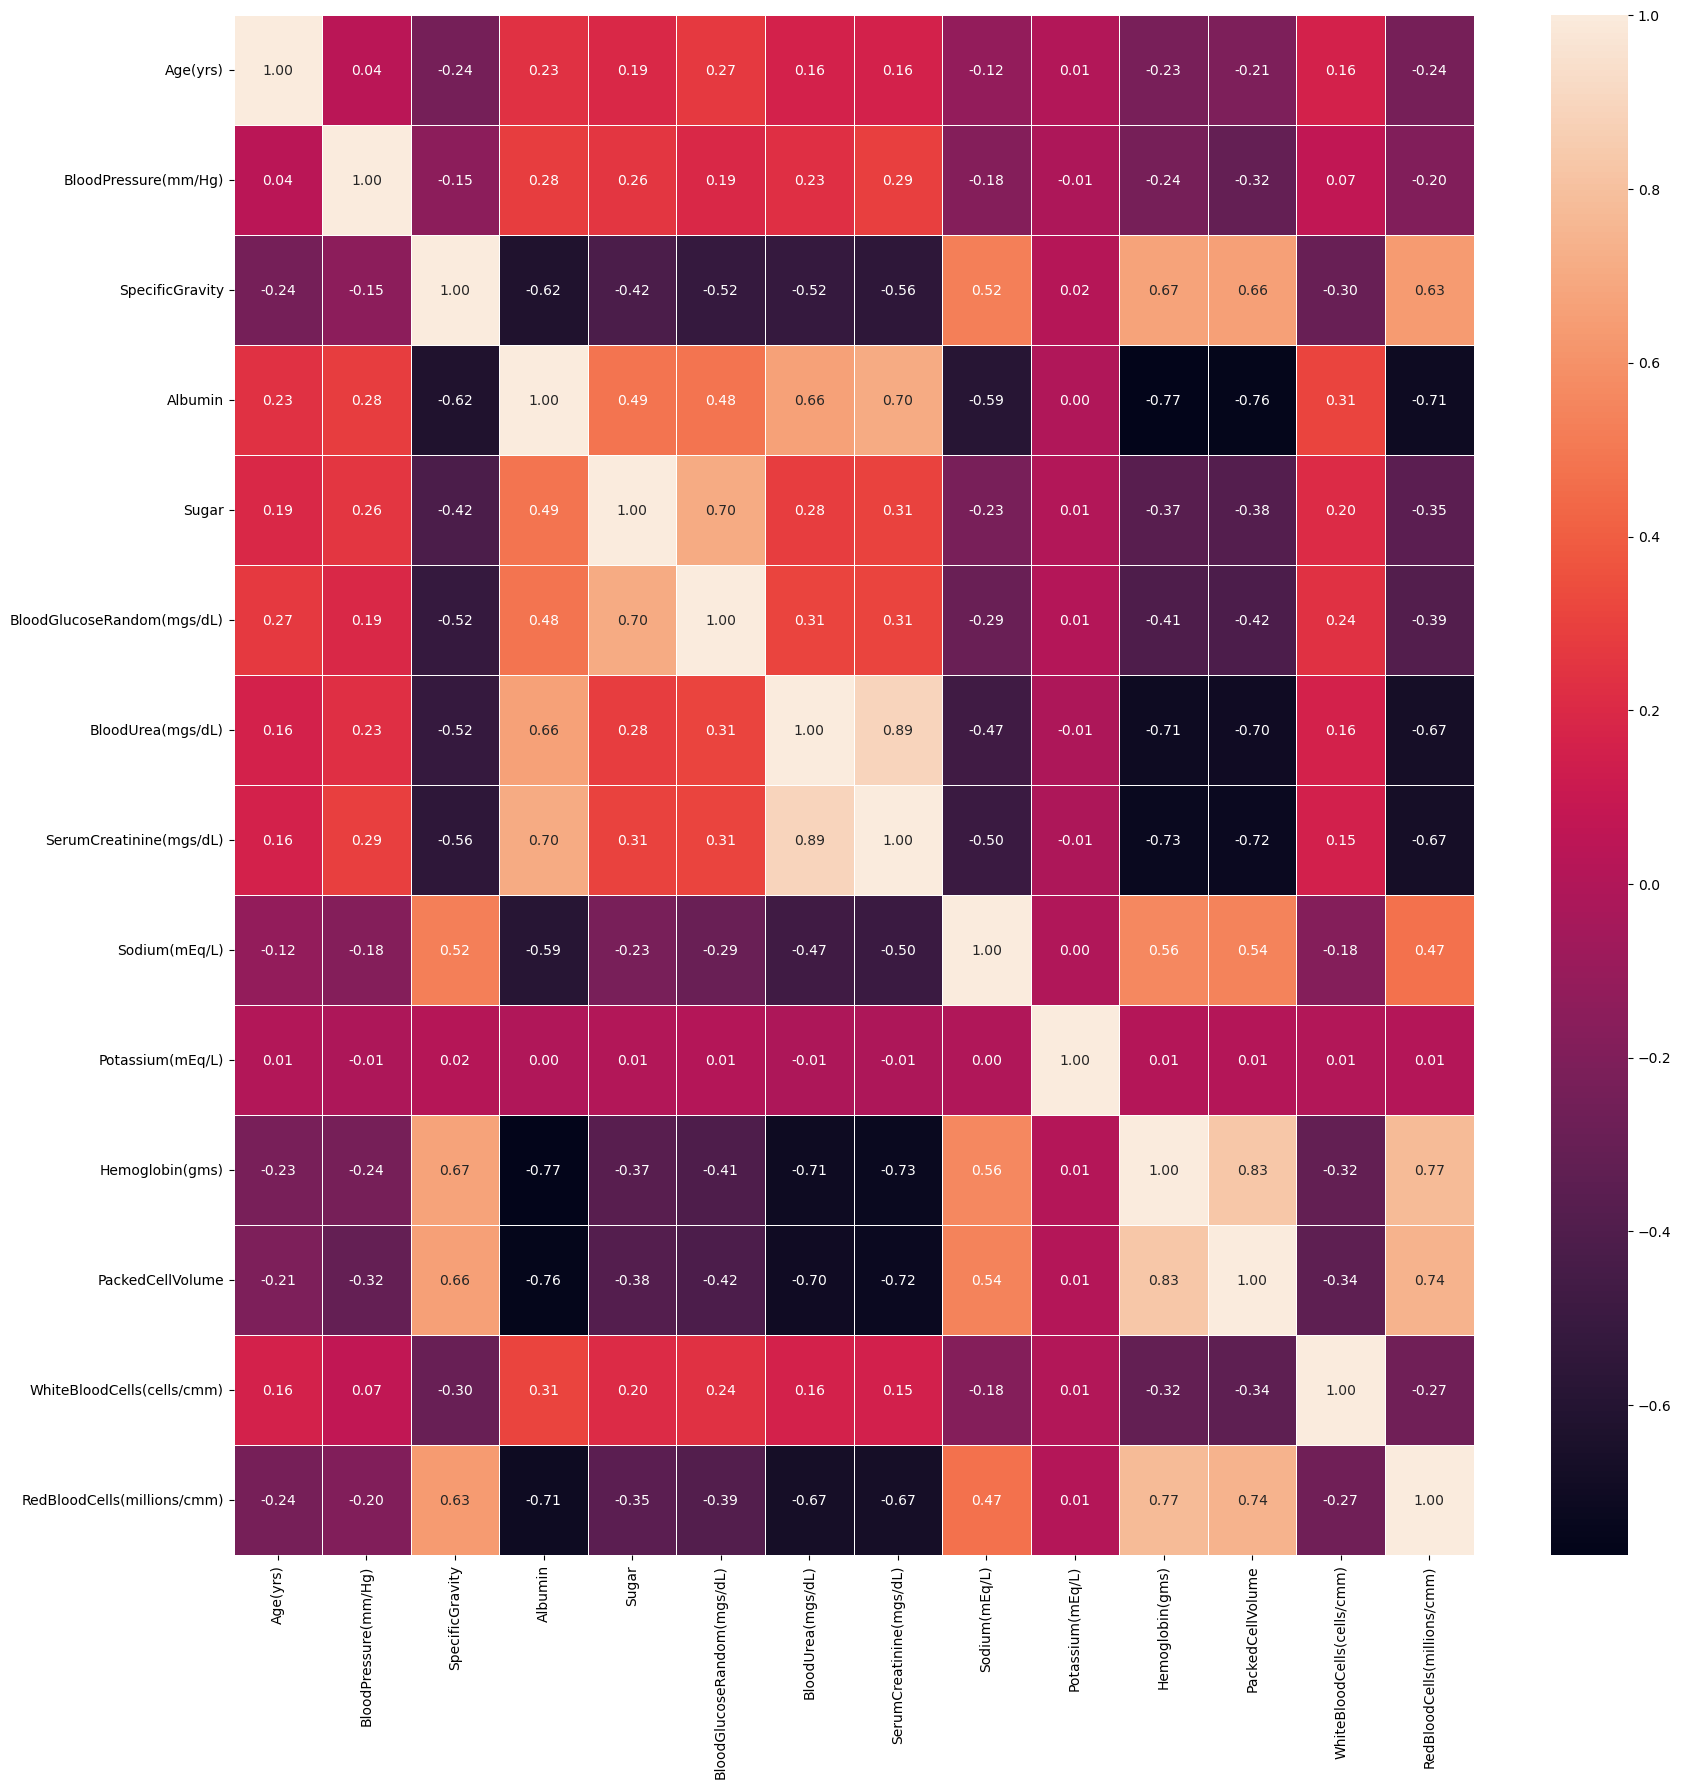

In [38]:
import seaborn as sns
plt.figure(figsize = (20,20))
sns.heatmap(df.corr(), annot = True, fmt=".2f",linewidths=0.5)

# 2.4 Normalization

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3444 entries, 9 to 8834
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Age(yrs)                     3444 non-null   float64 
 1   BloodPressure(mm/Hg)         3444 non-null   float64 
 2   SpecificGravity              3444 non-null   float64 
 3   Albumin                      3444 non-null   float64 
 4   Sugar                        3444 non-null   float64 
 5   RedBloodCells                3444 non-null   category
 6   PusCells                     3444 non-null   category
 7   PusCellClumps                3444 non-null   category
 8   Bacteria                     3444 non-null   category
 9   BloodGlucoseRandom(mgs/dL)   3444 non-null   float64 
 10  BloodUrea(mgs/dL)            3444 non-null   float64 
 11  SerumCreatinine(mgs/dL)      3444 non-null   float64 
 12  Sodium(mEq/L)                3444 non-null   float64 
 13  Pot

In [40]:
cat= df.select_dtypes(include=['float','category'])
cat

,Age(yrs),BloodPressure(mm/Hg),SpecificGravity,Albumin,Sugar,RedBloodCells,PusCells,PusCellClumps,Bacteria,BloodGlucoseRandom(mgs/dL),...,PackedCellVolume,WhiteBloodCells(cells/cmm),RedBloodCells(millions/cmm),Hypertension,DiabetesMellitus,CoronaryArteryDisease,Appetite,PedalEdema,Anemia,ChronicKidneyDisease
9,48.0,80.0,1.020,0.0,0.0,1,1,0,0,122.0,...,45.0,9500.0,4.6,0,0,0,0,1,1,0
10,30.0,80.0,1.020,0.0,0.0,1,1,0,0,82.0,...,45.0,9400.0,5.3,0,0,1,0,1,1,0
13,25.0,80.0,1.025,0.0,0.0,1,1,0,0,121.0,...,48.0,6900.0,5.3,0,0,0,1,0,0,0
14,55.0,80.0,1.020,0.0,0.0,1,1,0,0,140.0,...,45.0,6700.0,4.6,0,0,0,1,0,0,0
15,30.0,80.0,1.020,0.0,0.0,1,1,0,0,82.0,...,45.0,9400.0,5.3,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8829,59.0,50.0,1.010,3.0,0.0,1,0,0,0,241.0,...,31.0,15700.0,3.8,0,1,0,0,1,1,1
8830,59.0,50.0,1.010,3.0,0.0,1,0,0,0,241.0,...,31.0,15700.0,3.8,0,1,1,1,0,1,1
8832,73.0,70.0,1.005,0.0,0.0,1,1,0,0,70.0,...,29.0,18900.0,3.5,1,1,0,1,0,0,1
8833,73.0,60.0,1.020,2.0,0.0,0,1,0,0,120.0,...,33.0,7200.0,4.3,1,1,0,1,0,0,1


In [41]:
from sklearn.preprocessing import MinMaxScaler

# assume your data is a 2D array or a pandas dataframe named 'data'
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(cat)

In [42]:
normalized_data

array([[0.54545455, 0.5       , 0.75      , ..., 1.        , 1.        ,
        0.        ],
       [0.31168831, 0.5       , 0.75      , ..., 1.        , 1.        ,
        0.        ],
       [0.24675325, 0.5       , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.87012987, 0.33333333, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.87012987, 0.16666667, 0.75      , ..., 0.        , 0.        ,
        1.        ],
       [0.50649351, 0.16666667, 0.25      , ..., 0.        , 0.        ,
        1.        ]])

# 3. Data Preprocessing

# 3.1 Data Augmentation

In [43]:
# import splitfolders
# splitfolders.ratio(
#     "CTscaninput/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/",
#    output="./splittedImageDataset",
#    seed=7,
#    ratio=(0.8,0.1, 0.1)
# )

# 3.2 Image Data Generator

In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

In [45]:
cat.columns

Index(['Age(yrs)', 'BloodPressure(mm/Hg)', 'SpecificGravity', 'Albumin',
       'Sugar', 'RedBloodCells', 'PusCells', 'PusCellClumps', 'Bacteria',
       'BloodGlucoseRandom(mgs/dL)', 'BloodUrea(mgs/dL)',
       'SerumCreatinine(mgs/dL)', 'Sodium(mEq/L)', 'Potassium(mEq/L)',
       'Hemoglobin(gms)', 'PackedCellVolume', 'WhiteBloodCells(cells/cmm)',
       'RedBloodCells(millions/cmm)', 'Hypertension', 'DiabetesMellitus',
       'CoronaryArteryDisease', 'Appetite', 'PedalEdema', 'Anemia',
       'ChronicKidneyDisease'],
      dtype='object')

# 3.3 Data Splitting

In [46]:
from sklearn.model_selection import  RandomizedSearchCV, train_test_split
X = cat.drop(['ChronicKidneyDisease'], axis = 1)
y = cat['ChronicKidneyDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 60)

In [47]:
X_train

,Age(yrs),BloodPressure(mm/Hg),SpecificGravity,Albumin,Sugar,RedBloodCells,PusCells,PusCellClumps,Bacteria,BloodGlucoseRandom(mgs/dL),...,Hemoglobin(gms),PackedCellVolume,WhiteBloodCells(cells/cmm),RedBloodCells(millions/cmm),Hypertension,DiabetesMellitus,CoronaryArteryDisease,Appetite,PedalEdema,Anemia
8236,59.0,60.0,1.020,0.0,0.0,1,1,0,0,113.0,...,15.3,54.0,6500.0,4.9,0,0,0,1,0,1
1887,33.0,80.0,1.025,0.0,0.0,1,1,0,0,100.0,...,14.3,43.0,6700.0,5.9,0,0,0,1,1,1
2948,43.0,60.0,1.025,0.0,0.0,1,1,0,0,108.0,...,17.0,52.0,7200.0,5.8,0,0,0,1,0,0
8652,71.0,70.0,1.020,0.0,0.0,1,1,0,0,81.0,...,14.7,44.0,9800.0,6.0,0,0,0,1,0,0
3821,28.0,60.0,1.025,0.0,0.0,1,1,0,0,79.0,...,17.6,51.0,6500.0,5.0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5530,57.0,80.0,1.020,0.0,0.0,1,1,0,1,133.0,...,14.8,46.0,6600.0,5.5,0,0,0,1,1,0
6293,43.0,60.0,1.025,0.0,0.0,1,1,0,0,108.0,...,17.0,52.0,7200.0,5.8,0,0,1,1,0,0
3663,62.0,70.0,1.025,3.0,0.0,1,1,0,0,122.0,...,12.6,39.0,7900.0,3.9,1,1,0,1,0,0
8068,41.0,80.0,1.020,0.0,0.0,1,1,0,0,122.0,...,17.1,41.0,9100.0,5.2,0,0,0,1,0,0


In [48]:
X_test

,Age(yrs),BloodPressure(mm/Hg),SpecificGravity,Albumin,Sugar,RedBloodCells,PusCells,PusCellClumps,Bacteria,BloodGlucoseRandom(mgs/dL),...,Hemoglobin(gms),PackedCellVolume,WhiteBloodCells(cells/cmm),RedBloodCells(millions/cmm),Hypertension,DiabetesMellitus,CoronaryArteryDisease,Appetite,PedalEdema,Anemia
7512,60.0,60.0,1.015,5.0,1.0,1,0,1,0,288.0,...,8.0,24.0,15200.0,3.3,1,0,0,0,1,1
2744,49.0,100.0,1.010,3.0,0.0,1,0,0,0,129.0,...,8.1,24.0,9600.0,3.5,1,1,0,1,0,0
76,44.0,60.0,1.025,0.0,0.0,1,1,0,0,96.0,...,14.3,41.0,7200.0,5.0,0,0,0,1,0,0
3820,28.0,60.0,1.025,0.0,0.0,1,1,0,0,79.0,...,17.6,51.0,6500.0,5.0,0,0,0,1,0,0
7170,63.0,70.0,1.025,0.0,0.0,1,1,0,0,130.0,...,13.4,41.0,7300.0,4.7,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6123,55.0,100.0,1.015,1.0,4.0,0,1,0,0,297.0,...,11.2,34.0,13600.0,4.4,1,1,0,1,0,0
7969,37.0,60.0,1.025,0.0,0.0,1,1,0,0,111.0,...,16.2,50.0,5500.0,5.7,0,0,1,1,0,0
6315,58.0,70.0,1.025,0.0,0.0,1,1,0,0,88.0,...,16.4,53.0,9100.0,5.2,0,0,0,0,1,0
7172,39.0,60.0,1.020,0.0,0.0,1,1,0,0,86.0,...,13.6,51.0,5800.0,4.5,0,0,0,0,1,1


In [49]:
y_train

8236    0
1887    0
2948    0
8652    0
3821    0
       ..
5530    0
6293    0
3663    1
8068    0
5770    1
Name: ChronicKidneyDisease, Length: 2066, dtype: category
Categories (2, int64): [0, 1]

In [50]:
y_test

7512    1
2744    1
76      0
3820    0
7170    0
       ..
6123    1
7969    0
6315    0
7172    0
2787    1
Name: ChronicKidneyDisease, Length: 1378, dtype: category
Categories (2, int64): [0, 1]

# 4. Feature Selection

# 4.1 Standardize data

In [51]:
# StandardScaler
from sklearn.preprocessing import StandardScaler
scaler2 = StandardScaler()
X_train = scaler2.fit_transform(X_train)
X_test = scaler2.transform(X_test)

# 4.2 Principal Components

In [52]:
# Create a PCA object with all components
from sklearn.decomposition import PCA
pca1 = PCA(n_components=None)

# Fit the PCA model to the data
pca1.fit(X_train)

# Get the explained variance ratio for each component
explained_variance = pca1.explained_variance_ratio_

# Calculate the cumulative explained variance ratio
cumulative_variance = np.cumsum(explained_variance)

# Find the number of components that explain 95% of the variance
n_components = np.argmax(cumulative_variance >= 0.95) + 1

In [53]:
n_components

18

In [54]:
# Perform PCA to reduce the number of features

pca = PCA(n_components)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# 5. Prediction

In [55]:
X_train

array([[-1.48109229, -0.0434079 ,  0.20515784, ..., -0.25409152,
         0.23771559, -0.16717211],
       [-1.82386143,  1.42301288, -0.16931344, ...,  0.03349723,
        -0.18103255,  0.18949893],
       [-2.14518958, -1.02793846,  0.02612779, ...,  0.56150017,
        -0.20781089,  0.0274228 ],
       ...,
       [ 2.05812208, -0.994354  ,  0.32263566, ...,  1.29049058,
        -2.59944303,  0.15370809],
       [-1.095964  , -0.91653459,  0.31596021, ..., -0.45483698,
         0.20304683,  0.28394145],
       [ 4.80513587, -0.47589272,  4.4721918 , ..., -0.0660931 ,
         1.80945581,  1.1511446 ]])

# 5.1 Model Selection

In [56]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()

# 5.2 Model Training

In [57]:
classifier.fit(X_train, y_train)

DecisionTreeClassifier()

# 5.3 Prediction Model

In [58]:
Y_pred = classifier.predict(X_test)

In [59]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, Y_pred))
print(classification_report(y_test, Y_pred))

[[1042    2]
 [   3  331]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1044
           1       0.99      0.99      0.99       334

    accuracy                           1.00      1378
   macro avg       1.00      0.99      1.00      1378
weighted avg       1.00      1.00      1.00      1378



In [60]:
from sklearn.metrics import accuracy_score
X_test_prediction = classifier.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, y_test)
test_data_accuracy

0.9963715529753265

In [61]:
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

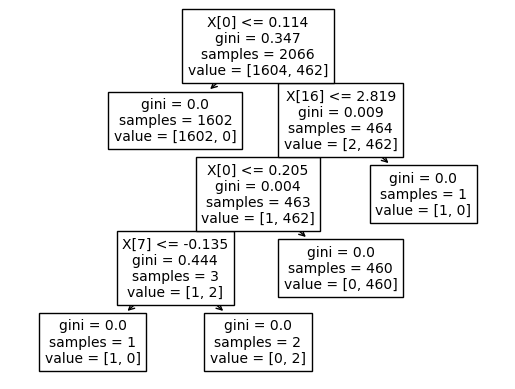

In [62]:
tree.plot_tree(classifier);

# 5.1 Model Selection

In [63]:
from sklearn.linear_model import LogisticRegression 
l1= LogisticRegression()

# 5.2 Model Training

In [64]:
l1.fit(X_train,y_train)

LogisticRegression()

# 5.3 Prediction Model

In [65]:
y_pred_min_robust=l1.predict(X_test)
y_pred_min_robust

array([1, 1, 0, ..., 0, 0, 1], dtype=int64)

In [66]:
from sklearn.metrics import accuracy_score
ac2=accuracy_score(y_test,y_pred_min_robust)*100
ac2

99.7822931785196

In [67]:
print(confusion_matrix(y_test, y_pred_min_robust))
print(classification_report(y_test, y_pred_min_robust))

[[1043    1]
 [   2  332]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1044
           1       1.00      0.99      1.00       334

    accuracy                           1.00      1378
   macro avg       1.00      1.00      1.00      1378
weighted avg       1.00      1.00      1.00      1378



In [68]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB

In [69]:
modelgnb = GaussianNB()
modelgnb.fit(X_train, y_train)
y_pred = modelgnb.predict(X_test)
modelgnb.score(X_test, y_test)

0.9898403483309144

In [70]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1030   14]
 [   0  334]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1044
           1       0.96      1.00      0.98       334

    accuracy                           0.99      1378
   macro avg       0.98      0.99      0.99      1378
weighted avg       0.99      0.99      0.99      1378



In [71]:
#Adaboost
from sklearn.ensemble import  AdaBoostClassifier
model = AdaBoostClassifier(n_estimators=3)
# Train Adaboost Classifer
model.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)
print("AdaBoost Classifier Model Accuracy:", accuracy_score(y_test, y_pred))

AdaBoost Classifier Model Accuracy: 0.9970972423802612


In [72]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1042    2]
 [   2  332]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1044
           1       0.99      0.99      0.99       334

    accuracy                           1.00      1378
   macro avg       1.00      1.00      1.00      1378
weighted avg       1.00      1.00      1.00      1378



In [78]:
# import Support Vector Classifier
from sklearn.svm import SVC
svc=SVC(probability=True, kernel='linear')


# train adaboost classifer
svc.fit(X_train, y_train)

# predict test dataset
y_pred = svc.predict(X_test)

# calculate and print model accuracy
print("Model Accuracy with SVC Base Estimator:",accuracy_score(y_test, y_pred))

Model Accuracy with SVC Base Estimator: 0.997822931785196


In [79]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
from sklearn.metrics import accuracy_score
print("Model Test Accuracy : {0:0.4f}".format(accuracy_score(y_test,y_pred)))
print("Model Train Accuracy : {0:0.4f}".format(accuracy_score(y_train,y_pred_train)))

Model Test Accuracy : 0.9971
Model Train Accuracy : 1.0000


In [80]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1042    2]
 [   2  332]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1044
           1       0.99      0.99      0.99       334

    accuracy                           1.00      1378
   macro avg       1.00      1.00      1.00      1378
weighted avg       1.00      1.00      1.00      1378



In [80]:
#KNN

In [81]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors = 3)

In [82]:
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [83]:
X_train_prediction = model.predict(X_train)
train_data_accuracy = accuracy_score(X_train_prediction, y_train)
train_data_accuracy

0.9975798644724104

In [84]:
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, y_test)
test_data_accuracy

0.9956458635703919

In [85]:
print(confusion_matrix(y_test, X_test_prediction))
print(classification_report(y_test, X_test_prediction))

[[1042    2]
 [   4  330]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1044
           1       0.99      0.99      0.99       334

    accuracy                           1.00      1378
   macro avg       1.00      0.99      0.99      1378
weighted avg       1.00      1.00      1.00      1378



In [86]:
#Random forest

In [87]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

In [88]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [89]:
clf.fit(X_train, y_train);

In [90]:
y_preds = clf.predict(X_test)
y_preds

array([1, 1, 0, ..., 0, 0, 1], dtype=int64)

In [91]:
accuracy_score(y_test, y_preds)

0.997822931785196

In [92]:
print(confusion_matrix(y_test, y_preds))
print(classification_report(y_test, y_preds))

[[1042    2]
 [   1  333]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1044
           1       0.99      1.00      1.00       334

    accuracy                           1.00      1378
   macro avg       1.00      1.00      1.00      1378
weighted avg       1.00      1.00      1.00      1378



In [93]:
#VGG-16

In [94]:
# splitfolders.ratio(
#     "CTscaninput/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
#    output="./dataset",
#    seed=7,
#    ratio=(0.8,0.1, 0.1)
# )

In [95]:
train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

In [96]:
train_dataset = train_datagen.flow_from_directory('./dataset/train',
                                                  target_size=(200, 200),
                                                  color_mode='grayscale', 
                                                  class_mode='categorical', 
                                                  batch_size=100,
                                                  )
test_dataset = test_datagen.flow_from_directory('./dataset/test',
                                                target_size=(200, 200),
                                                class_mode='categorical',
                                                color_mode='grayscale',
                                                batch_size=100,
                                                shuffle=False
                                                )
valid_dataset = valid_datagen.flow_from_directory('./dataset/val',
                                                  target_size=(200, 200),
                                                  class_mode='categorical',
                                                  batch_size=100,
                                                  color_mode='grayscale',
                                                  )

Found 9955 images belonging to 4 classes.
Found 1249 images belonging to 4 classes.
Found 1242 images belonging to 4 classes.


In [97]:
model = tf.keras.models.Sequential([
  
    tf.keras.layers.Conv2D(32,(3,3),strides=(1, 1),activation='relu',padding='same', input_shape=train_dataset.image_shape), 
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(64,(3,3),strides=(1, 1) ,padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(128,(3,3),strides=(1, 1),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(256,(3,3),strides=(1, 1),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),


    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax'),
 
])

In [98]:
import keras
METRICS = [
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
    
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=METRICS)

In [99]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 128)      0

In [100]:
model_fit = model.fit(train_dataset,
                      validation_data=valid_dataset,
                      steps_per_epoch = 3,
                      epochs = 30)

Epoch 1/30
3/3 [==============================] - 23s 10s/step - loss: 1.4667 - accuracy: 0.3867 - precision: 0.4000 - recall: 0.1333 - val_loss: 1.3795 - val_accuracy: 0.2979 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 22s 9s/step - loss: 1.3608 - accuracy: 0.3667 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.2796 - val_accuracy: 0.4082 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 25s 10s/step - loss: 1.3138 - accuracy: 0.4100 - precision: 0.7209 - recall: 0.1033 - val_loss: 1.2919 - val_accuracy: 0.4082 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
3/3 [==============================] - 32s 13s/step - loss: 1.2829 - accuracy: 0.4367 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.2326 - val_accuracy: 0.4082 - val_precision: 0.7682 - val_recall: 0.2295
Epoch 5/30
3/3 [==============================] - 35s 15s/step - loss: 1.2255

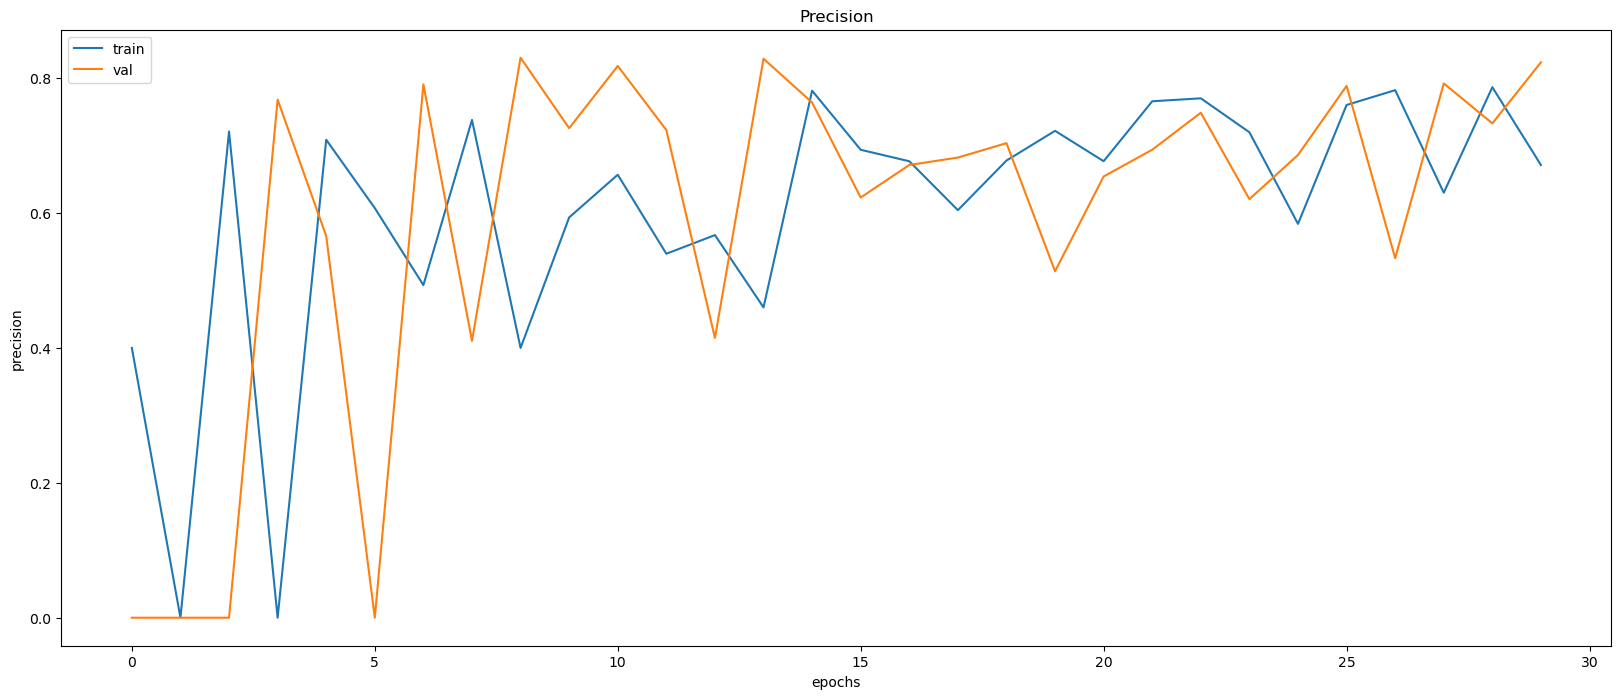

In [116]:
plt.figure(figsize=(20, 8))
# ax = ax.ravel()

# for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
# ax[0].plot(model_fit.history['precision'])
#     ax[i].plot(model_fit.history['val_' + met])
#     ax[i].set_title('Model {}'.format(met))
#     ax[i].set_xlabel('epochs')
#     ax[i].set_ylabel(met)
#     ax[i].legend(['train', 'val'])
plt.plot(model_fit.history['precision'])
plt.plot(model_fit.history['val_precision'])
plt.title('Precision')
plt.ylabel('precision')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

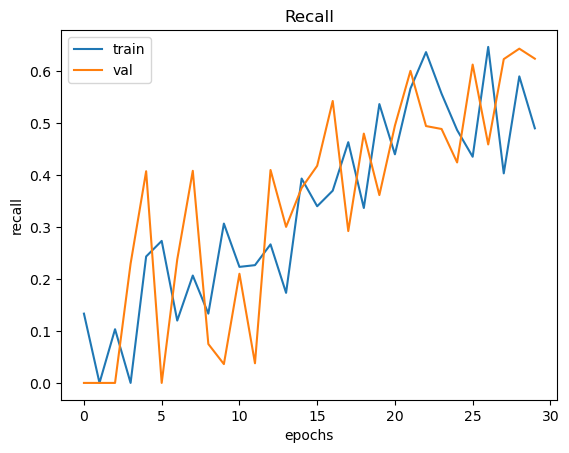

In [117]:
plt.plot(model_fit.history['recall'])
plt.plot(model_fit.history['val_recall'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

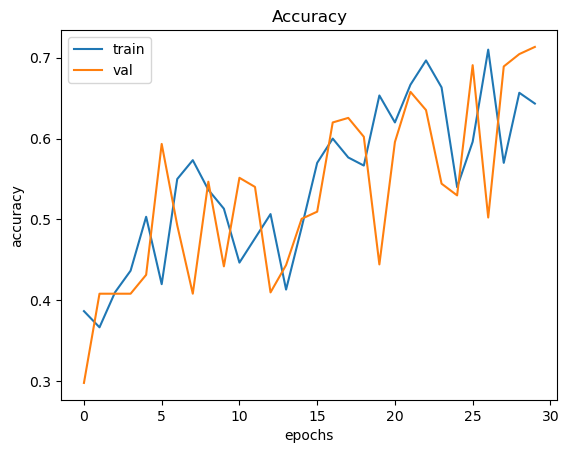

In [118]:
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

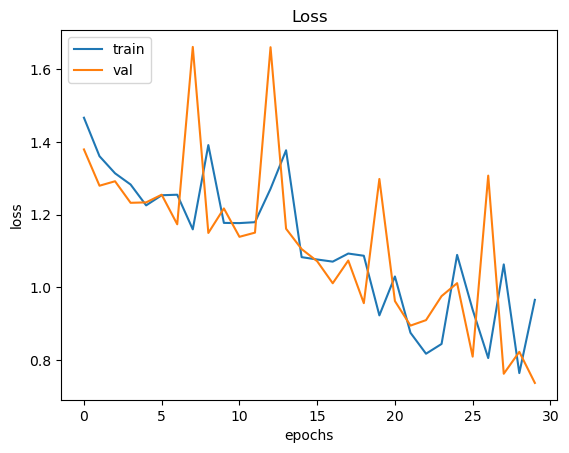

In [120]:
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [119]:
predictions = model.predict(test_dataset)

13/13 [==============================] - 14s 1s/step


In [121]:
diseases_labels = []

for key, value in train_dataset.class_indices.items():
   diseases_labels.append(key)

In [122]:
from sklearn.metrics import precision_recall_fscore_support
def evaluate(actual, predictions):
  pre = []
  for i in predictions:
    pre.append(np.argmax(i))

  accuracy = (pre == actual).sum() / actual.shape[0]
  print(f'Accuracy: {accuracy}')

  precision, recall, f1_score, _ = precision_recall_fscore_support(actual, pre, average='macro')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1_score: {f1_score}')

  fig, ax = plt.subplots(figsize=(20,20))
  conf_mat = confusion_matrix(actual, pre)
  sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap="YlGnBu", xticklabels=diseases_labels, yticklabels=diseases_labels).set_title('Confusion Matrix Heat map')
  plt.show()

Accuracy: 0.7077662129703763
Precision: 0.7881021876783206
Recall: 0.5506837668789043
F1_score: 0.5408331453140467


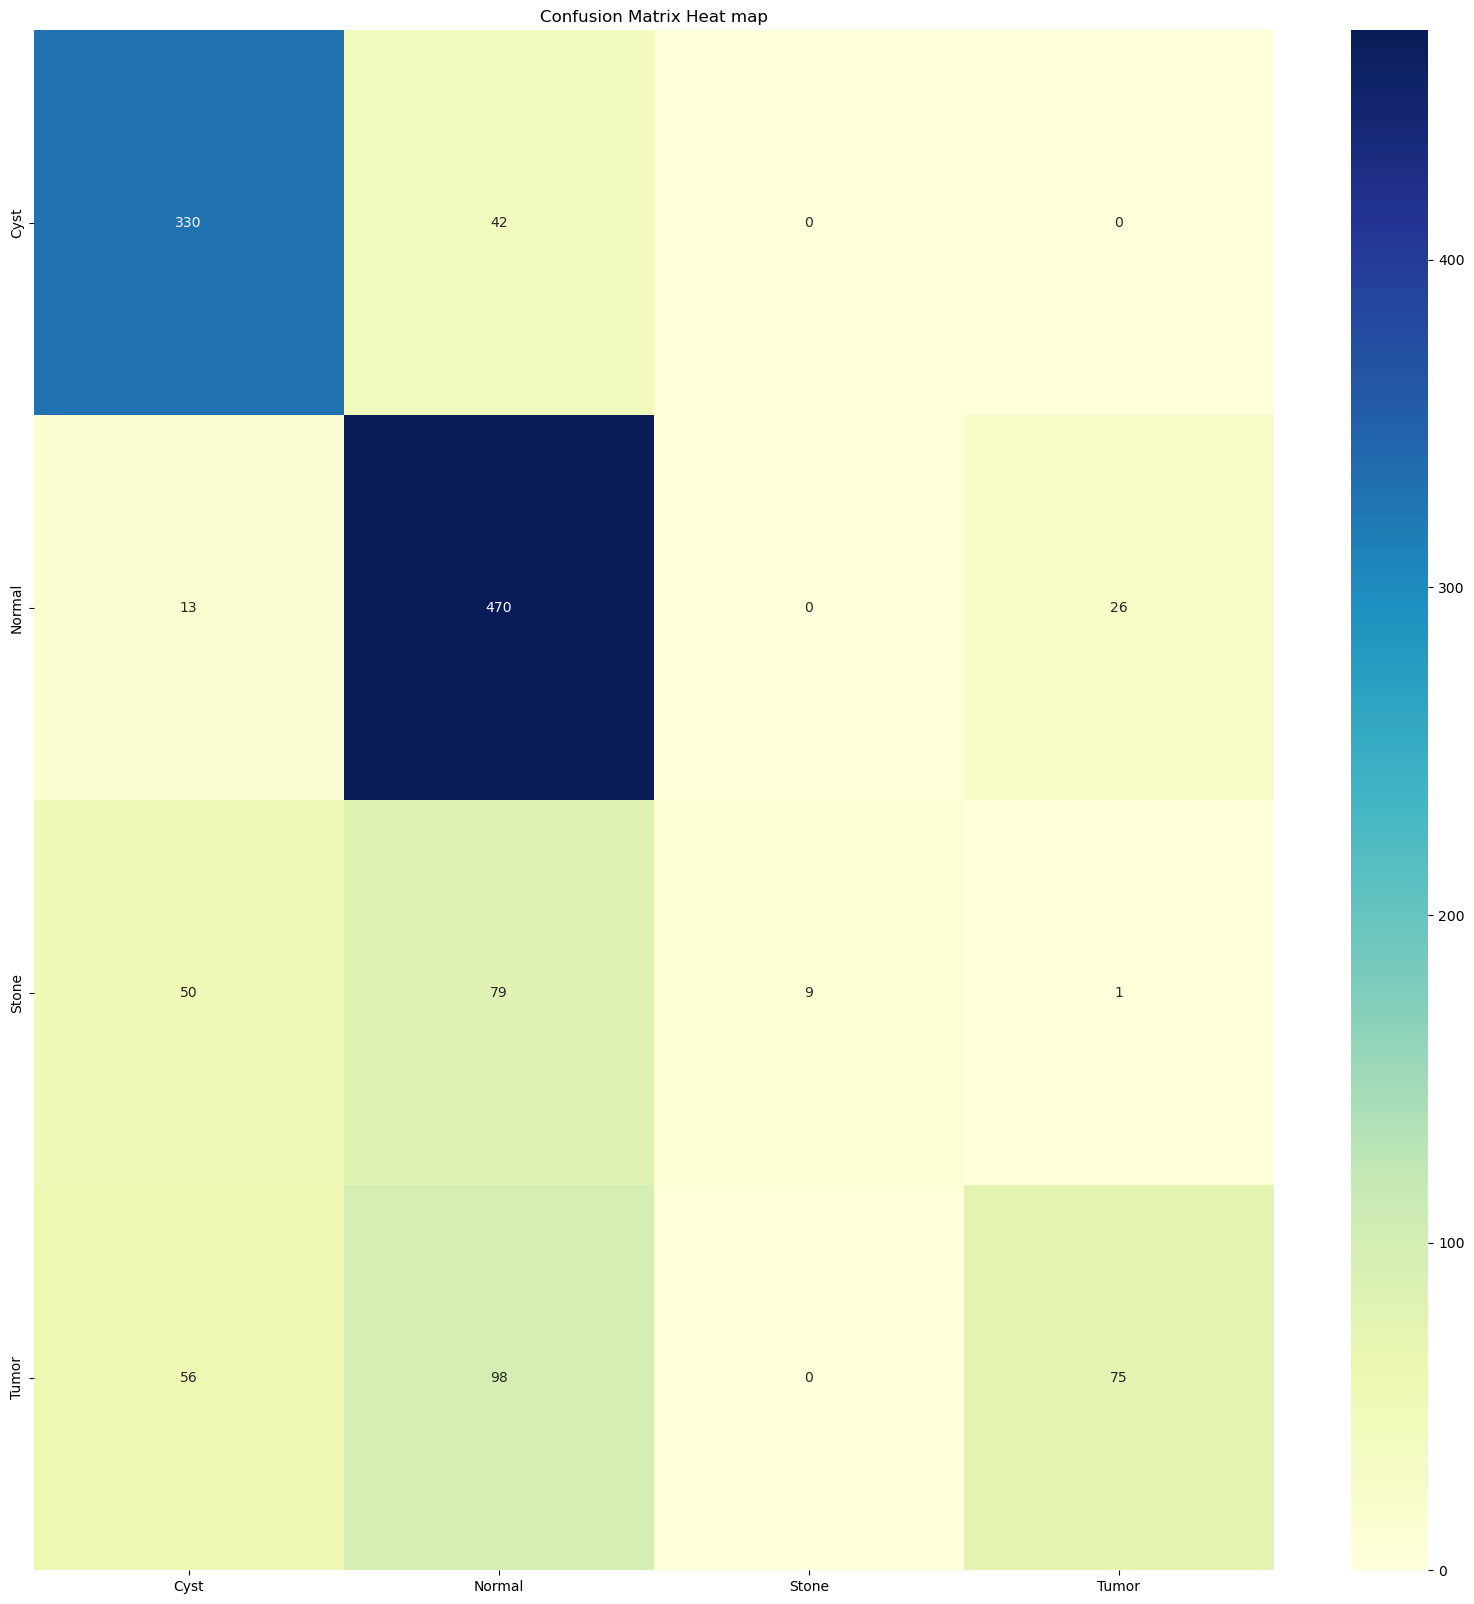

In [126]:
evaluate(test_dataset.classes,predictions)

In [124]:
model.evaluate(test_dataset)

13/13 [==============================] - 10s 773ms/step - loss: 0.7315 - accuracy: 0.7078 - precision: 0.8356 - recall: 0.6269


[0.7315319180488586,
 0.7077662348747253,
 0.8356456756591797,
 0.6269015073776245]

In [95]:
#Resnet

In [59]:
train_dataset = train_datagen.flow_from_directory('./dataset/train',
                                                  target_size=(200, 200),
                                                  color_mode='rgb', 
                                                  class_mode='categorical', 
                                                  batch_size=100,
                                                  )
test_dataset = test_datagen.flow_from_directory('./dataset/test',
                                                target_size=(200, 200),
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                batch_size=100,
                                                shuffle=False
                                                )
valid_dataset = valid_datagen.flow_from_directory('./dataset/val',
                                                  target_size=(200, 200),
                                                  class_mode='categorical',
                                                  batch_size=100,
                                                  color_mode='rgb',
                                                  )

Found 9955 images belonging to 4 classes.
Found 1249 images belonging to 4 classes.
Found 1242 images belonging to 4 classes.


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 

import tensorflow as tf
tf.config.run_functions_eagerly(True)
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings("ignore") 

plt.rcParams['font.size'] = 10

In [61]:
conda list

# packages in environment at C:\Users\Ganesh\anaconda3:
#
# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0            py39haa95532_0  
absl-py                   1.4.0                    pypi_0    pypi
alabaster                 0.7.12             pyhd3eb1b0_0  
anaconda                  2022.10                  py39_0  
anaconda-client           1.11.0           py39haa95532_0  
anaconda-navigator        2.3.2            py39haa95532_0  
anaconda-project          0.11.1           py39haa95532_0  
anyio                     3.5.0            py39haa95532_0  
appdirs                   1.4.4              pyhd3eb1b0_0  
argon2-cffi               21.3.0             pyhd3eb1b0_0  
argon2-cffi-bindings      21.2.0           py39h2bbff1b_0  
arrow                     1.2.2              pyhd3eb1b0_0  
astroid                   2.11.7           py39haa95532_0  
astropy                   5.1              py39h080aedc_0  
astunparse                1.6

In [62]:
# pip install tensorflow_hub

In [69]:
img_size = 200
batch_size =100
Model_URL ='https://kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-classification/versions/2'
model = Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(img_size, img_size, 3)),
    hub.KerasLayer(Model_URL),
    tf.keras.layers.Dense(4, activation="softmax")])

In [70]:
model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"] 
  )

In [71]:
model.build((img_size, img_size, 3))

In [72]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 keras_layer_2 (KerasLayer)  (None, 1001)              25615849  
                                                                 
 dense_2 (Dense)             (None, 4)                 4008      
                                                                 
Total params: 25,619,857
Trainable params: 4,008
Non-trainable params: 25,615,849
_________________________________________________________________


In [73]:
model_name = "model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

 

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5,
                                                 verbose = 1, restore_best_weights=True)

reduce_lr = tf._keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [74]:
history = model.fit(train_dataset,
                      validation_data=valid_dataset,
                      steps_per_epoch = 3,
                      epochs = 30)

Epoch 1/30
3/3 [==============================] - 165s 49s/step - loss: 1.4995 - accuracy: 0.3300 - val_loss: 1.4352 - val_accuracy: 0.2681
Epoch 2/30
3/3 [==============================] - 137s 55s/step - loss: 1.4307 - accuracy: 0.3500 - val_loss: 1.4592 - val_accuracy: 0.4058
Epoch 3/30
3/3 [==============================] - 134s 54s/step - loss: 1.4463 - accuracy: 0.3833 - val_loss: 1.3108 - val_accuracy: 0.4469
Epoch 4/30
3/3 [==============================] - 149s 59s/step - loss: 1.3333 - accuracy: 0.3933 - val_loss: 1.3258 - val_accuracy: 0.3309
Epoch 5/30
3/3 [==============================] - 146s 57s/step - loss: 1.3095 - accuracy: 0.4000 - val_loss: 1.2734 - val_accuracy: 0.4557
Epoch 6/30
3/3 [==============================] - 135s 52s/step - loss: 1.2312 - accuracy: 0.4700 - val_loss: 1.2800 - val_accuracy: 0.4364
Epoch 7/30
3/3 [==============================] - 130s 53s/step - loss: 1.2477 - accuracy: 0.4700 - val_loss: 1.2376 - val_accuracy: 0.5072
Epoch 8/30
3/3 [====

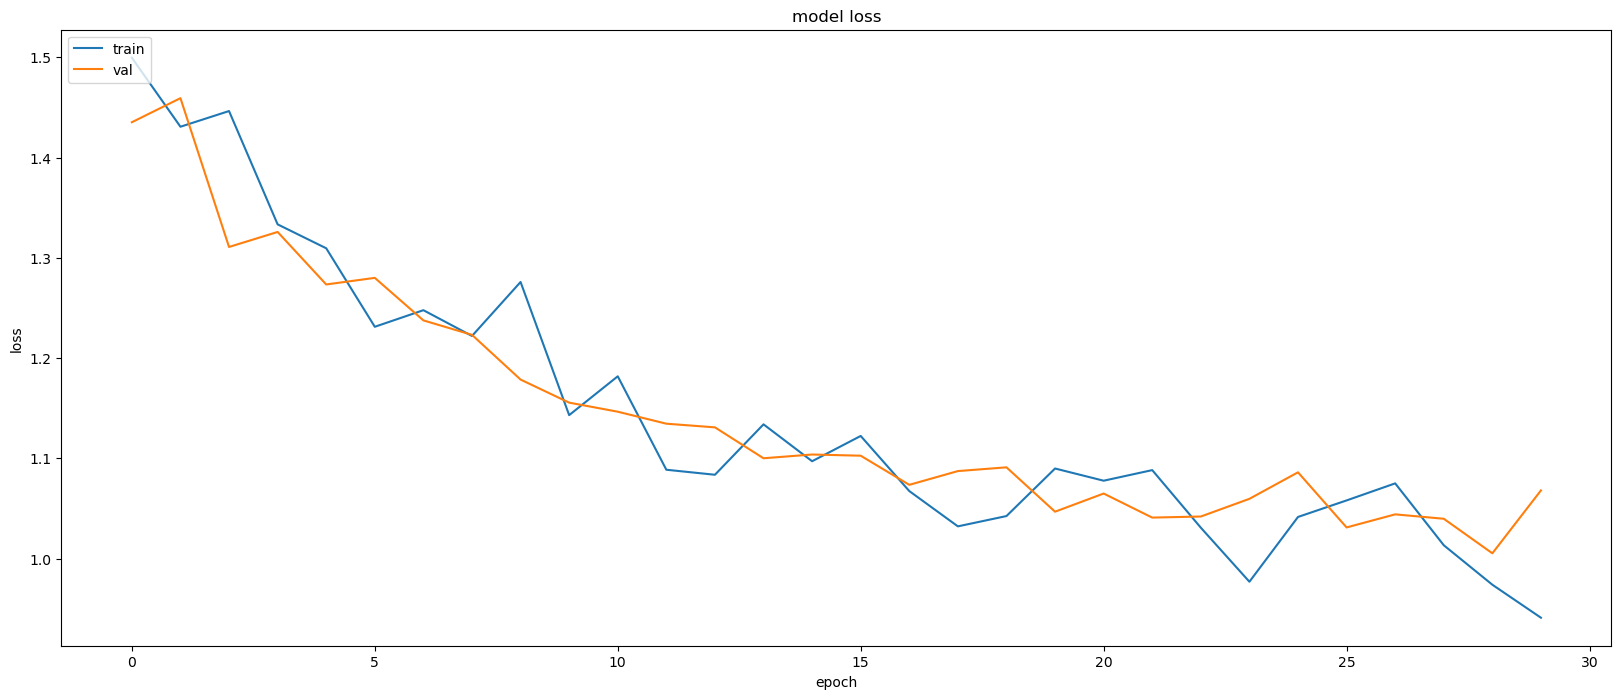

In [75]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

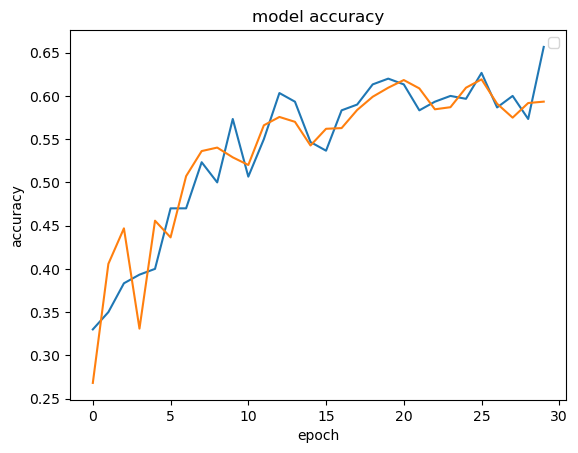

In [76]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [84]:
loss, accuracy = model.evaluate(test_dataset)

13/13 [==============================] - 78s 6s/step - loss: 1.0629 - accuracy: 0.6005


In [87]:
print(f"Accuracy is: {round(accuracy*100,2)}%")

Accuracy is: 75.05%
